# Masking data
---

In case of implicit filtering there's difficulty to run filtering only for a selected part of the data.
Here is a demonstration how this can be done.

In this example synthetic data on regular mesh is used

In [32]:
import numpy as np
import math
# Mesh size
Lx = 1000
Ly = Lx
# Mesh resolution
dxm = 10
dym = dxm
r_earth = 6371

### Create mesh

In [43]:
### Create mesh
xx = np.arange(0, Lx + 1, dxm)
yy = np.arange(0, Ly + 1, dym)

nx = len(xx)
ny = len(yy)

nodnum = np.arange(0, nx * ny)
xcoord = np.zeros((nx, ny))
ycoord = xcoord.copy()

for i in range(nx):
    ycoord[i, :] = yy

for i in range(ny):
    xcoord[:, i] = xx

xcoord /= r_earth
ycoord /= r_earth
alpha = 0
zg = np.sin(ycoord)
xg = np.cos(ycoord) * np.cos(xcoord)
yg = np.cos(ycoord) * np.sin(xcoord)
# Rotate by alpha
zn = zg * np.cos(alpha) + xg * np.sin(alpha)
xg = -zg * np.sin(alpha) + xg * np.cos(alpha)
# New coordinates in radians
ycoord = np.arcsin(zn)
xcoord = np.arctan2(yg,xg)
# New coordinates in degrees
ycoord = (180/math.pi) * np.arcsin(zn)
xcoord = (180/math.pi) * np.arctan2(yg,xg)

### Create synthetic data with given spectra slope

In [44]:
tt = 50 * (np.random.random(xcoord.shape) - 0.5)
ttf = np.fft.fft2(tt)
# ============
# Make spectrum red
# ============
espectrum = np.zeros((nx // 2 + 1))  # Place for Fourier spectrum
kk = np.concatenate((np.arange(0, nx // 2 + 1), np.arange(-nx // 2 + 1, 0, 1)))  # Wavenumbers

for mx in range(nx):
    for my in range(ny):
        ll = np.sqrt(kk[my] * kk[my] + kk[mx] * kk[mx])  # Absolute value
        if my == 0 and mx == 0:  # Remove area mean
            ttf[my, mx] = 0.0
        else:  # Adjust amplitudes
            tmp = ttf[my, mx] / (np.power(ll, 1.5))  # 1.5 for -2 spectrum
            ttf[my, mx] = tmp
        if ll + 1 <= nx // 2 + 1:
            espectrum[np.floor(ll).astype(int)] += ttf[my, mx] * np.conj(ttf[my, mx])

espectrum = espectrum / np.power(nx, 4)

tt = np.real(np.fft.ifft2(ttf))  # We expect that it will show - 2 spectrum

/var/folders/p7/__mkfjf91fd70x4d4rzgvsq0rx9_k9/T/ipykernel_91966/2588423314.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  espectrum[np.floor(ll).astype(int)] += ttf[my, mx] * np.conj(ttf[my, mx])


### Reshape arrays and make triangulation

/var/folders/p7/__mkfjf91fd70x4d4rzgvsq0rx9_k9/T/ipykernel_91966/3385834945.py:4: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plt.pcolor(xcoord, ycoord, tt, shading='auto')


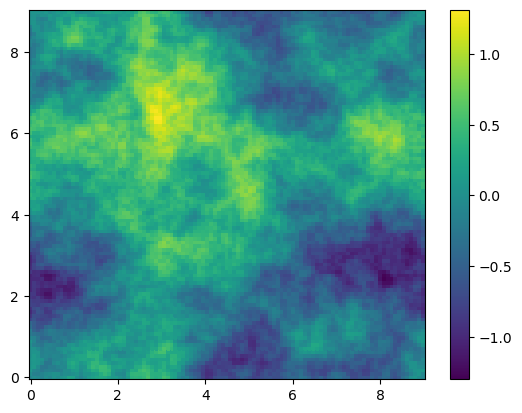

In [45]:
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.pcolor(xcoord, ycoord, tt, shading='auto')
plt.colorbar()

Now part of this data needs to be masked (eg. land mask)

In [46]:
mask = np.logical_and(xcoord < 2, ycoord < 3)
masked_data = tt.copy()
masked_data[mask] = 0.0

/var/folders/p7/__mkfjf91fd70x4d4rzgvsq0rx9_k9/T/ipykernel_91966/2774221042.py:1: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plt.pcolor(xcoord, ycoord, masked_data, shading='auto')


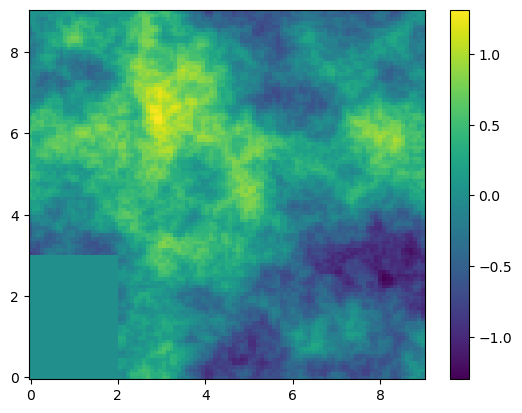

In [47]:
plt.pcolor(xcoord, ycoord, masked_data, shading='auto')
plt.colorbar()

### There are two way to handle such situation:

 1. Create filter specific for masked mesh
 2. Create filter for the whole mesh and fill unwanted data with neutreal value

### Solution 1: Mesh specific filter

Filter created with given mask is specific to this exact mask.
In case of any changes to the mask, new filter must be created. In this case mask must be placed on mesh elements

In [58]:
from implicit_filter import LatLonFilter

flter = LatLonFilter()
flter.prepare(xcoord[:, 0], ycoord[0, :], cartesian=False, mask=np.logical_not(mask))

In [8]:
from implicit_filter import transform_mask_from_nodes_to_elements

elem_mask = transform_mask_from_nodes_to_elements

In [60]:
tts = flter.compute(1, 2 * math.pi / 50., tt)

The part that wasn't filtered is clearly visible

/var/folders/p7/__mkfjf91fd70x4d4rzgvsq0rx9_k9/T/ipykernel_91966/2493258328.py:1: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plt.pcolor(xcoord, ycoord, tts, shading='auto')


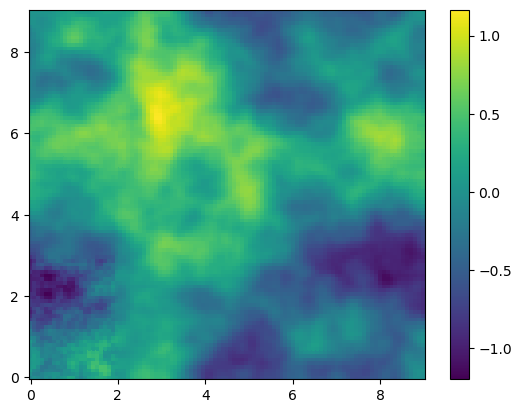

In [61]:
plt.pcolor(xcoord, ycoord, tts, shading='auto')
plt.colorbar()

It's even better visible when looking at the difference between filtered and original data

/var/folders/p7/__mkfjf91fd70x4d4rzgvsq0rx9_k9/T/ipykernel_91966/2163752700.py:1: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plt.pcolor(xcoord, ycoord, tts - tt, shading='auto')


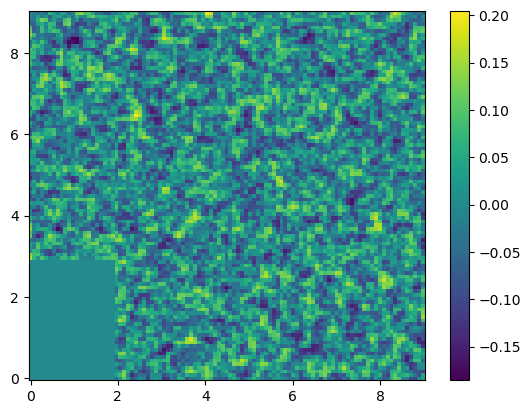

In [62]:
plt.pcolor(xcoord, ycoord, tts - tt, shading='auto')
plt.colorbar()

### Solution 2: Filling with neutral value

The selected area should be filled with neutral value related to given variable.
Usually it's 0, but it might not work for all.

This method should be used with caution as results might different than expected.
Especially conservation laws might not be respected

/var/folders/p7/__mkfjf91fd70x4d4rzgvsq0rx9_k9/T/ipykernel_91966/2746864827.py:3: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plt.pcolor(xcoord, ycoord, masked_data, shading='auto')


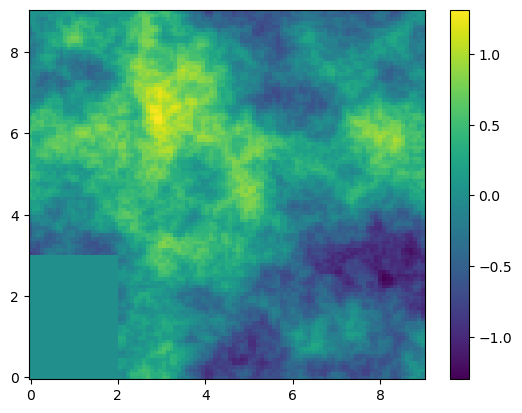

In [64]:
masked_data[mask] = 0.0

plt.pcolor(xcoord, ycoord, masked_data, shading='auto')
plt.colorbar()

In this solution, the filter for the entire mesh can be used all the time.

In [65]:
from implicit_filter import LatLonFilter

flter = LatLonFilter()
flter.prepare(xcoord[:, 0], ycoord[0, :], cartesian=False, mask=np.logical_not(mask))

In [66]:
tts = flter.compute(1, 2 * math.pi / 100., masked_data)
tts[mask] = 0.0 # Reapply mask for the filtered data

/var/folders/p7/__mkfjf91fd70x4d4rzgvsq0rx9_k9/T/ipykernel_91966/2493258328.py:1: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plt.pcolor(xcoord, ycoord, tts, shading='auto')


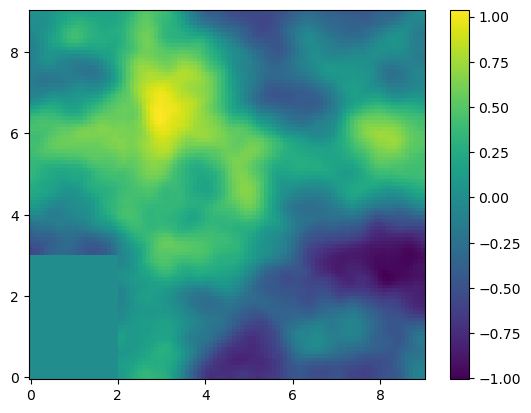

In [67]:
plt.pcolor(xcoord, ycoord, tts, shading='auto')
plt.colorbar()

/var/folders/p7/__mkfjf91fd70x4d4rzgvsq0rx9_k9/T/ipykernel_91966/3831885205.py:1: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plt.pcolor(xcoord, ycoord, tts - masked_data, shading='auto')


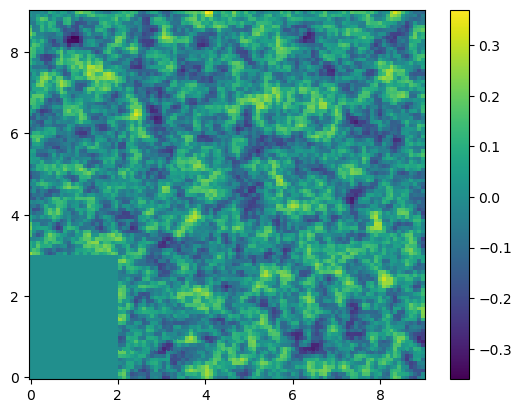

In [69]:
plt.pcolor(xcoord, ycoord, tts - masked_data, shading='auto')
plt.colorbar()


## Extracting spectra

Regardless of the used method extracting spectra looks the same

In [78]:
kc = np.array([2, 4, 6, 8, 10, 12, 16, 20, 24, 30, 40, 50]) * dxm
kc = 2 * math.pi / kc  # Wavenumbers

In [79]:
spectra = flter.compute_spectra_scalar(1, kc, tt, mask=np.logical_not(mask).flatten())

Text(0, 0.5, '$ \\bar E $')

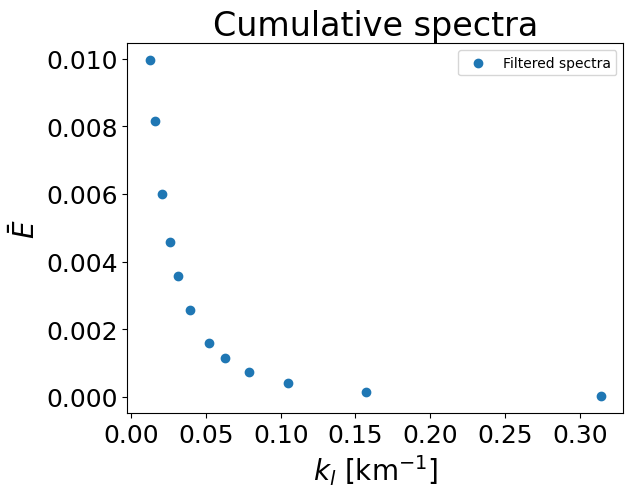

In [81]:
# Skip the first element as spectra also contains value for unfiltered data on position 0
plt.scatter(kc, spectra[1:], label="Filtered spectra")
plt.title("Cumulative spectra", fontsize=24)
plt.legend()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"$k_l$ [km$^{-1}$]", fontsize=20)
plt.ylabel(r"$ \bar E $", fontsize=20)